In [14]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pandas as pd
import scipy as scp
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pickle
import matplotlib.gridspec as gridspec
import fastkde

<h2 style="font-size:28px; font-weight:bold;">Preparing Data</h2>

In [15]:
file_path1 = 'SSTs.nc'
file_path2 = 'TCs.nc'
  
                                  
ds1 = xr.open_dataset(file_path1)
ds2 = xr.open_dataset(file_path2)

/Users/varinradia/anaconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [16]:
ds_grouped = ds1.groupby('time.year').mean(dim='time')                                   #Obtained Yearly Meaned Data
tropical_data = ds_grouped.sel(latitude=slice(23.5, -23.5), longitude=slice(0, 360))    #Extracted Data For the Tropics

In [17]:
with open("storms_by_year.pk", "rb") as fin:  
 storms = pickle.load(fin)

<h2 style="font-size:28px; font-weight:bold;">Exctracting lat and lon data for each storm that were sorted by year</h2>

In [18]:
# Initialize a dictionary to store storm information with latitudes and longitudes
storm_info = {}

# Iterate over the years in the storms dictionary
for year, storm_ids_year in storms.items():
    # Initialize a dictionary to store storm information for the current year
    storm_info_year = {}
    # Iterate over the storm IDs for the current year
    for storm_id in storm_ids_year:
        # Find the storm data for the current storm ID
        storm_data = ds2.sel(storm=storm_id)
        # Extract latitude and longitude values
        latitudes = storm_data['lat'].values
        longitudes = storm_data['lon'].values
        # Store latitude and longitude values in the storm_info_year dictionary
        storm_info_year[storm_id] = {'lat': latitudes, 'lon': longitudes}
    # Store storm information for the current year in the storm_info dictionary
    storm_info[year] = storm_info_year

<h2 style="font-size:28px; font-weight:bold;">Analyzing the Relationship Between SST and Tropical Cyclone Genesis Across 5°x5° grid Boxes</h2>

In [19]:
lat_edges = np.arange(-20, 21, 5)
lon_edges = np.arange(0, 360, 5)

result = {}  # Re-initializing the dictionary to store the results

# Iterating over each year in the tropical data
for year in tropical_data['year'].values:
    # Selecting SST data for the current year
    sst_data = tropical_data.sel(year=year)['sst']
    # Calculating the mean SST across all latitudes and longitudes for the year, skipping NaN values
    tropical_mean_sst = sst_data.mean(dim=['latitude', 'longitude'], skipna=True).item()

    # Iterating over each grid box defined by latitude and longitude edges
    for lat_start, lat_end in zip(lat_edges[:-1], lat_edges[1:]):
        for lon_start, lon_end in zip(lon_edges[:-1], lon_edges[1:]):
            # Selecting data for the current grid box
            grid_box_data = sst_data.sel(latitude=slice(lat_end, lat_start), longitude=slice(lon_start, lon_end))

            if grid_box_data.size > 0:
                # Calculating the mean SST for the current grid box, skipping NaN values
                grid_box_mean_sst = grid_box_data.mean(dim=['latitude', 'longitude'], skipna=True).item()

                # Calculating deltaSST
                deltaSST = grid_box_mean_sst - tropical_mean_sst

                if grid_box_mean_sst > tropical_mean_sst:
                    tc_starts = 0  # Initializing the counter for tropical cyclones starting in this grid box
                    if year in storm_info:
                        for storm_data in storm_info[year].values():
                            storm_lat = storm_data['lat'][0]  # Getting the starting latitude of the storm
                            storm_lon = storm_data['lon'][0]  # Getting the starting longitude of the storm
                            if lat_start <= storm_lat <= lat_end and lon_start <= (storm_lon + 360) % 360 <= lon_end:
                                tc_starts += 1

                    # Storing the results for the current year and grid box
                    if year not in result:
                        result[year] = []
                    result[year].append({
                        'gridbox': f'{lat_start}-{lat_end}, {lon_start}-{lon_end}',
                        'avg_sst': grid_box_mean_sst,
                        'deltaSST': deltaSST,  # Adding deltaSST to the results
                        'TCs_started': tc_starts,
                        'year': year
                    })
            else:
                print(f"Grid box {lat_start}-{lat_end}, {lon_start}-{lon_end} is empty.")


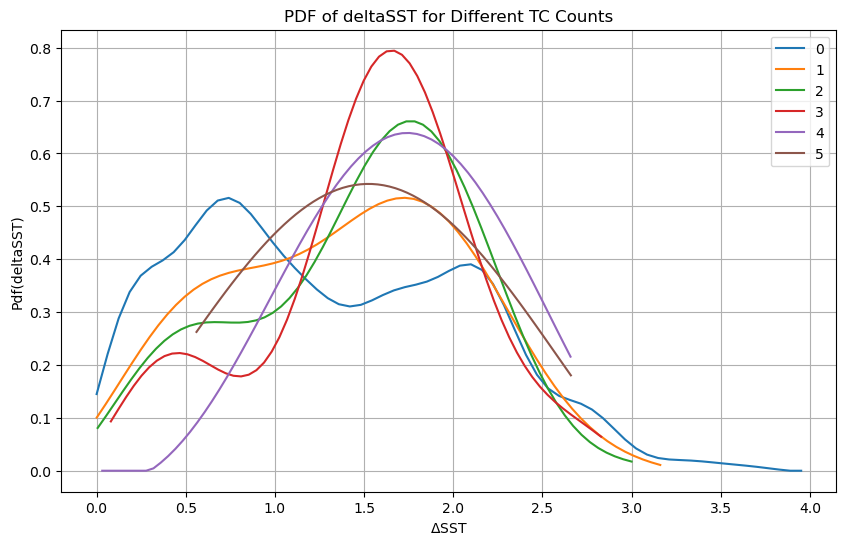

In [20]:
dsst = []  
sst = []
tc = []  
for year in result:
    for data in result[year]:  
        dsst.append(data['deltaSST'])
        sst.append(data['avg_sst'])  
        tc.append(data['TCs_started'])  


dsst = np.array(dsst)
tc = np.array(tc)
counts = [0,1, 2, 3, 4, 5]
plt.figure(figsize=(10, 6))

for count in counts:
    ii = np.nonzero(tc == count)[0]  
    dsst_at_this_count = dsst[ii]  
    cpdf = fastkde.pdf(dsst_at_this_count)  
    #plt.plot(cpdf, label=f'{count}')  
    cpdf.plot(label = f"{count}")

plt.title('PDF of deltaSST for Different TC Counts')
plt.xlabel('$\Delta$SST')
plt.ylabel('Pdf(deltaSST)')
plt.legend()  
plt.grid(True)  
plt.show()  


$$ P(i | \Delta \text{SST}) = \frac{P(\Delta \text{SST} | i)}{P(i)}$$

$$P(i) = \frac{N_i}{\sum N_i}$$

Here, $i$ is the number of TCs counted in a grid region, and $N_i$ is the number of observations with $i$ TCs in a cell.  In the code below, this is just `len(ii)`

/var/folders/1z/84y74_xs347cxhm6360l4xvm0000gn/T/ipykernel_6983/2769017162.py:20: RuntimeWarning: divide by zero encountered in divide
  P_i_dsst = P_dsst_i/P_dsst
/var/folders/1z/84y74_xs347cxhm6360l4xvm0000gn/T/ipykernel_6983/2769017162.py:20: RuntimeWarning: invalid value encountered in divide
  P_i_dsst = P_dsst_i/P_dsst


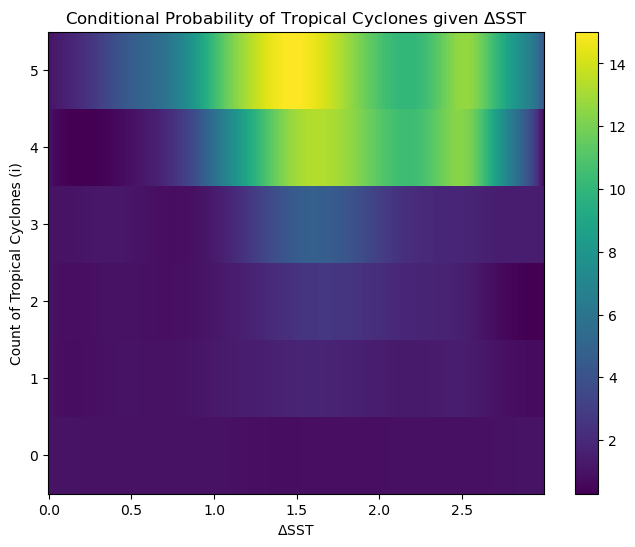

In [21]:
# calculate the marginal distrbution of dsst
P_dsst, sst_axis = fastkde.pdf(np.asarray(dsst), use_xarray = False, num_points= 1025)

# initialize P_dsst_i to have the correct shape
P_dsst_i = np.empty([len(counts), len(sst_axis)])


for count in counts:
    i = np.nonzero(tc == count)[0]  
    dsst_i = dsst[i]  
    # calculate P(dsst | i) at the same points that P(dsst) is calculate
    P_dsst_i[count, :], _ = fastkde.pdf(dsst_i, axes = [sst_axis], use_xarray = False) 

    P_i = len(np.nonzero(tc == count)[0]) / len(tc)

    P_dsst_i[count, :] = P_dsst_i[count, :] * P_i


# calculate the conditional of i | dsst
P_i_dsst = P_dsst_i/P_dsst

# convert to xarray
P_i_dsst = xr.DataArray(P_i_dsst, dims = ("i", "dsst"), coords = dict(i = counts, dsst = sst_axis))

# subset from 0 to 3
P_i_dsst = P_i_dsst.sel(dsst = slice(0,3))

# calculate the sst probability amplification factor (risk ratio)
P_dsst_0 = P_i_dsst.sel(dsst = 0, method = 'nearest')

cond_prob_amp = P_i_dsst / P_dsst_0

plt.figure(figsize=(8, 6))
cond_prob_amp.plot(cmap='viridis')
plt.xlabel('$\Delta$SST')
plt.ylabel('Count of Tropical Cyclones (i)')
plt.title('Conditional Probability of Tropical Cyclones given $\Delta$SST')
plt.show()